# Cellular models

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 7

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from Life import Life
from Life import LifeViewer

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

In [2]:
from scipy.signal import convolve2d

class Diffusion(Life):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, r=0.1):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        r: diffusion rate constant
        """
        self.r = r
        m = n if m is None else m
        self.array = np.zeros((n, m), np.float)

    def step(self):
        """Executes one time step."""
        c = convolve2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

In [3]:
class DiffusionViewer(LifeViewer):
    cmap = plt.get_cmap('Reds')

In [4]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
viewer = DiffusionViewer(diff)

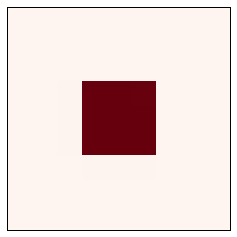

In [5]:
anim = viewer.animate()

In [6]:
anim

In [7]:
class ReactionDiffusion(Life):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    options = dict(mode='same', boundary='wrap')

    def __init__(self, n, m=None, params=(0.16, 0.08, 0.035, 0.065)):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        r: diffusion rate constant
        """
        
        def island(a, val, noise=None):
            """Adds an island in the middle of the grid.
            
            val: height of the island
            noise: magnitude of random noise
            """
            noise = val if noise is None else noise
            n, m = a.shape
            r = min(n, m) // 20
            a[n//2-r:n//2+r, m//2-r:m//2+r] = val
            a += noise * np.random.random((n, m))
        
        self.params = params
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=float)

        self.array2 = np.zeros((n, m), dtype=float)
        island(self.array2, val=0.1, noise=0.1)
        
    def step(self):
        """Executes one time step."""
        u = self.array
        v = self.array2
        ru, rv, f, k = self.params
        
        cu = convolve2d(u, self.kernel, **self.options)
        cv = convolve2d(v, self.kernel, **self.options)
        reaction = u * v**2
        self.array += ru * cu - reaction + f * (1-u) 
        self.array2 += rv * cv + reaction - (f+k) * v

In [8]:
class RDViewer(LifeViewer):
    """Generates images and animations."""
    
    cmapu = plt.get_cmap('Reds')
    cmapv = plt.get_cmap('Blues')

    options = dict(alpha=0.7,
                  interpolation='bicubic')
        
    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def step(self, iters=1):
        """Advances the viewee the given number of steps."""
        for i in range(iters):
            self.viewee.step()

    def draw_array(self):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=100)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

In [9]:
params1 = 0.5, 0.25, 0.035, 0.057   # white spots
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(100, params=params3)
viewer = RDViewer(rd)

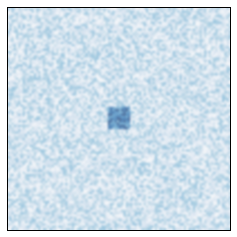

In [10]:
anim = viewer.animate(frames=100)

In [11]:
anim

In [12]:
def make_viewer(f, k, n=100):
    """Makes a ReactionDiffusion viewer with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params=params)
    viewer = RDViewer(rd)
    return viewer

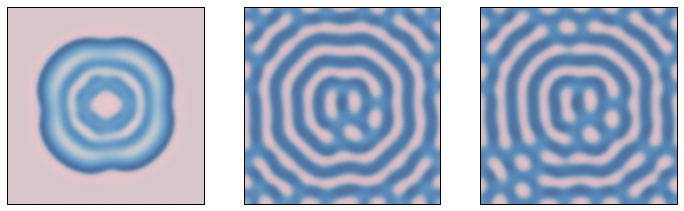

In [13]:
viewer = make_viewer(0.035, 0.057)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-1.pdf')

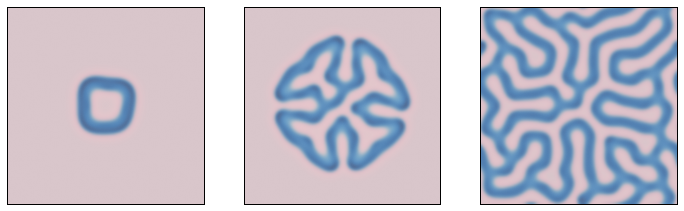

In [14]:
viewer = make_viewer(0.055, 0.062)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-2.pdf')

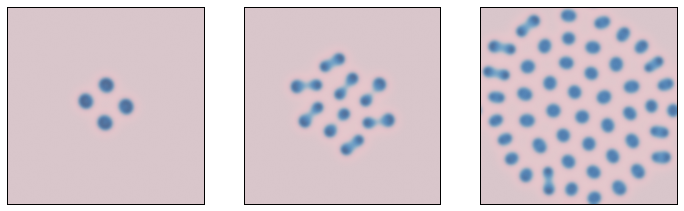

In [15]:
viewer = make_viewer(0.039, 0.065)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-3.pdf')

In [169]:
from scipy.signal import convolve2d

class Percolation(Life):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.5, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        """
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice(2, (n, m), p=[1-p, p])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = convolve2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>4)] = 5
        
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def num_porous(self):
        """Total number of porous cells."""
        return np.sum(self.array == 1)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)

In [155]:
class PercolationViewer(LifeViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='none', 
                   vmin=0, vmax=2)

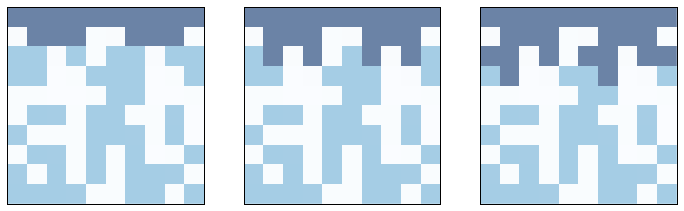

In [156]:
seed = 22
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)

thinkplot.preplot(cols=3)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step()
viewer.draw()

thinkplot.subplot(3)
viewer.step()
viewer.draw()

plt.savefig('chap07-4.pdf')

In [157]:
def test_perc(perc):
    num_wet = perc.num_wet()

    num_steps = 0
    while True:
        perc.step()
        num_steps += 1

        new_num_wet = perc.num_wet()

        if perc.bottom_row_wet():
            return True, num_steps
        
        if new_num_wet == num_wet:
            return False, num_steps

        num_wet = new_num_wet

In [158]:
perc = Percolation(10, p=0.5, seed=seed)
flag, num_steps = test_perc(perc)
print(flag, iters)

True 467


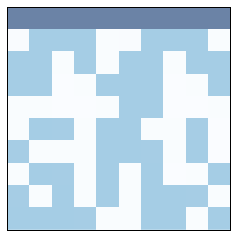

In [159]:
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)
anim = viewer.animate(frames=iters+1)

In [160]:
anim

In [161]:
def estimate_prob_spanning(p=0.5, n=100, iters=100):
    count = 0
    for i in range(iters):
        perc = Percolation(n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            count += 1
        
    return count / iters

In [162]:
fraction = estimate_prob_spanning(p=0.55)
print(fraction)

0.01


In [163]:
fraction = estimate_prob_spanning(p=0.6)
print(fraction)

0.67


In [164]:
fraction = estimate_prob_spanning(p=0.65)
print(fraction)

1.0


In [266]:
def find_critical(p=0.59, n=100, iters=100):
    """Estimate p_crit by random walk.
    
    returns: list of p that should wander around p_crit
    """
    ps = [p]
    for i in range(iters):
        perc = Percolation(n=n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            p -= 0.005
        else:
            p += 0.005
        ps.append(p)
    return ps

CPU times: user 9.45 s, sys: 0 ns, total: 9.45 s
Wall time: 9.45 s


0.590

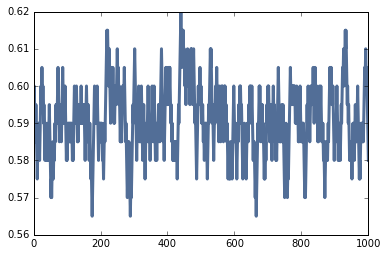

In [268]:
%time ps = find_critical(n=50, iters=1000)
thinkplot.plot(ps)
np.mean(ps)

CPU times: user 12 s, sys: 0 ns, total: 12 s
Wall time: 12 s


0.592

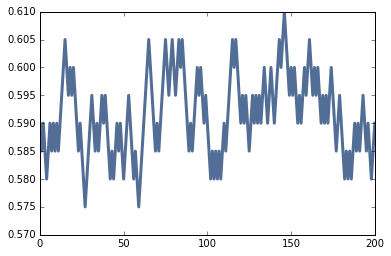

In [270]:
%time ps = find_critical(n=100, iters=200)
thinkplot.plot(ps)
np.mean(ps)

CPU times: user 17.7 s, sys: 4 ms, total: 17.7 s
Wall time: 17.7 s


0.598

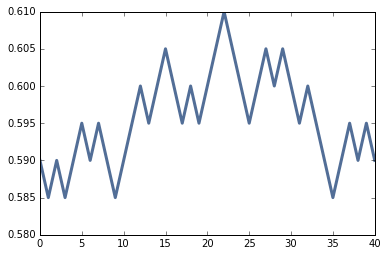

In [273]:
%time ps = find_critical(n=200, iters=40)
thinkplot.plot(ps)
np.mean(ps)

CPU times: user 42.8 s, sys: 4 ms, total: 42.8 s
Wall time: 42.8 s


0.587

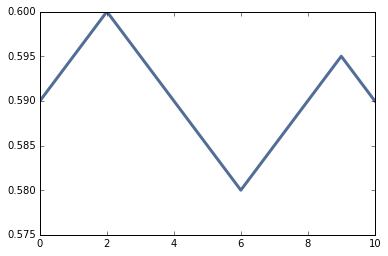

In [274]:
%time ps = find_critical(n=400, iters=10)
thinkplot.plot(ps)
np.mean(ps)

True 138


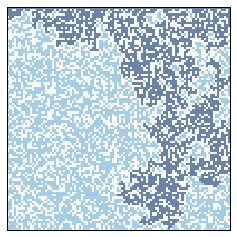

In [258]:
seed = 22
perc = Percolation(100, p=0.6, seed=seed)
flag, num_steps = test_perc(perc)
print(flag, num_steps)
viewer = PercolationViewer(perc)
viewer.draw()

False 467


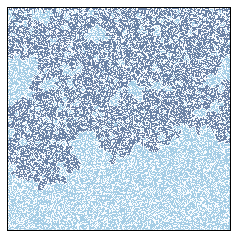

In [259]:
perc = Percolation(300, p=0.6, seed=seed)
flag, num_steps = test_perc(perc)
print(flag, num_steps)
viewer = PercolationViewer(perc)
viewer.draw()

In [275]:
def scale_perc(ns):
    """Run percolations with a range of n.
    
    ns: sequence of n
    
    returns: list of (num_wet, num_porous, num_filled) tuples
    """
    res = []
    for n in ns:
        perc = Percolation(n, p=0.58, seed=seed)
        num_wet = perc.num_wet()
        num_porous = perc.num_porous()
        flag, num_steps = test_perc(perc)
        num_filled = perc.num_wet()
        res.append((num_wet, num_porous, num_filled))
    return res

In [295]:
ns = np.linspace(50, 540, 50).astype(int)
print(ns)

[ 50  60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210 220
 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400
 410 420 430 440 450 460 470 480 490 500 510 520 530 540]


In [296]:
res = scale_perc(ns)

In [297]:
wet, porous, filled = zip(*res)

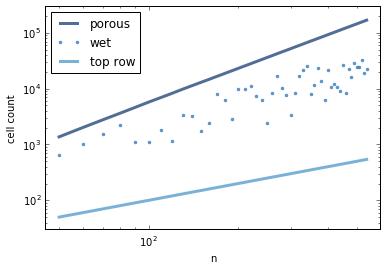

In [304]:
thinkplot.plot(ns, porous, label='porous')
thinkplot.plot(ns, filled, style='.', label='wet')
thinkplot.plot(ns, wet, label='top row')
thinkplot.config(xlabel='n',
                 ylabel='cell count',
                 xscale='log', xlim=[45, 600], 
                 yscale='log', ylim=[30, 300000],
                 loc='top left')

In [305]:
from scipy.stats import linregress

for ys in [wet, porous, filled]:
    params = linregress(np.log(ns), np.log(ys))
    print(params[0])

1.0
2.01344572567
1.49167355287


In [ ]:
class ForestFire(Life):
    """Forest Fire Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.5, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        """
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice(2, (n, m), p=[1-p, p])

    def step(self):
        """Executes one time step."""
        ???
        
    